In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# import sys
# sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
# from utils import 

df_eddies = pd.read_pickle(f'/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


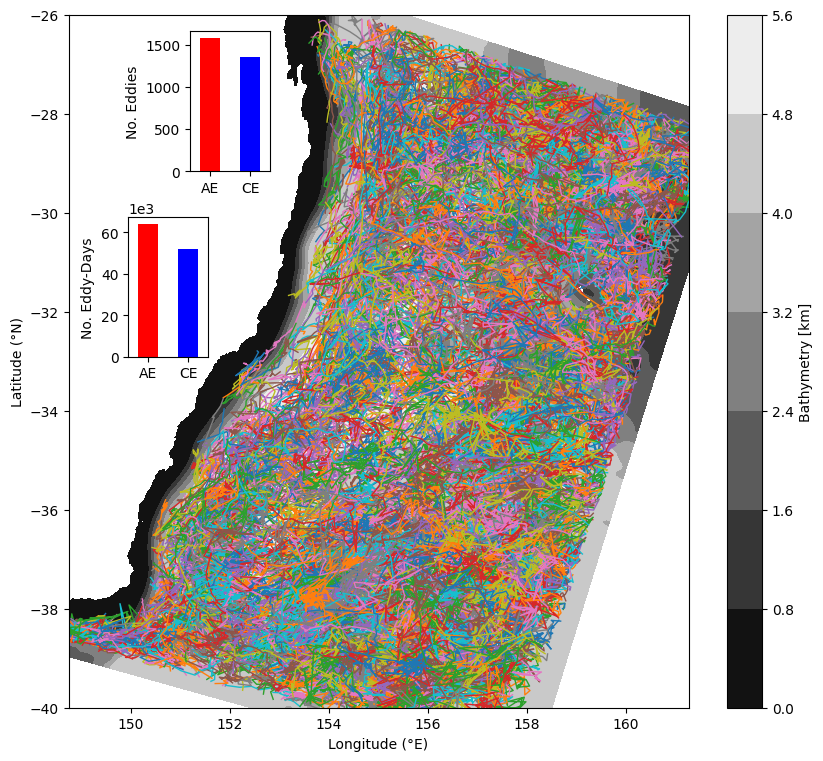

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(10,9))
cs = ax.contourf(lon_rho, lat_rho, np.where(mask_rho, h/1000, np.nan), cmap='grey')
plt.colorbar(cs, ax=ax, label='Bathymetry [km]')

for eddy in df_eddies.Eddy.unique():
    d = df_eddies[df_eddies.Eddy==eddy]
    cyc = d.iloc[0].Cyc
    # ax.plot(d.Lon, d.Lat, color='r' if cyc=='AE' else 'b', lw=1, alpha=1)
    ax.plot(d.Lon, d.Lat, lw=1, alpha=1)

ax.axis('equal')
ax.set_xlim(149, 161)
ax.set_ylim(-40, -26)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')

# Plot 1
df = df_eddies[['Eddy', 'Cyc']].copy().drop_duplicates()
# Fixed size in inches; anchor at data coords (148, -32)
in_ax1 = inset_axes(ax, width=.8, height=1.4, loc='center',
                   bbox_to_anchor=(152, -27.75, 0, 0),
                   bbox_transform=ax.transData, borderpad=0)
counts = df['Cyc'].value_counts().reindex(['AE','CE']).fillna(0)
counts.plot(kind='bar', color=['r','b'], ax=in_ax1)
# in_ax.set_xlabel('Eddy Cyclonicity')
in_ax1.set_xlabel('')
in_ax1.set_ylabel('No. Eddies')
in_ax1.tick_params(axis='x', rotation=0)
in_ax1.set_facecolor('none')  # transparent background (optional)

# plot 2
df = df_eddies[['Eddy', 'Cyc']].copy().drop_duplicates()
# Fixed size in inches; anchor at data coords (148, -32)
in_ax2 = inset_axes(ax, width=.8, height=1.4, loc='center',
                   bbox_to_anchor=(150.75, -31.5, 0, 0),
                   bbox_transform=ax.transData, borderpad=0)
counts = df_eddies['Cyc'].value_counts().reindex(['AE','CE']).fillna(0)
counts.plot(kind='bar', color=['r','b'], ax=in_ax2)
# in_ax2.set_xlabel('Eddy Cyclonicity')
in_ax2.set_xlabel('')
in_ax2.set_ylabel('No. Eddy-Days')
in_ax2.tick_params(axis='x', rotation=0)
in_ax2.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
in_ax2.set_facecolor('none')  # transparent background (optional)



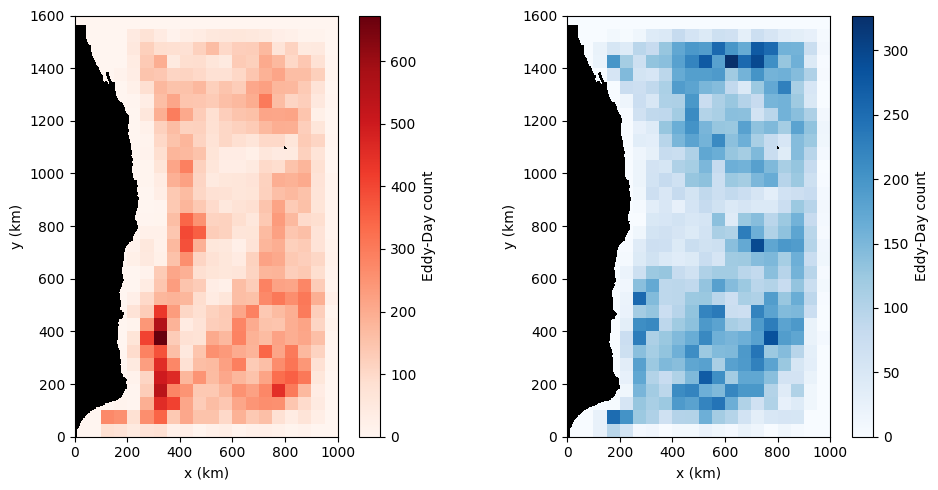

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for d, df in enumerate([df_eddies[df_eddies.Cyc == 'AE'], df_eddies[df_eddies.Cyc == 'CE']]):
    
    x0, y0 = X_grid[0, 0], Y_grid[0, 0]
    eddy_x = X_grid[df.ic, df.jc] - x0
    eddy_y = Y_grid[df.ic, df.jc] - y0
    
    bin_km = 50
    x_edges = np.arange(X_grid.min(), X_grid.max() + bin_km, bin_km)
    y_edges = np.arange(Y_grid.min(), Y_grid.max() + bin_km, bin_km)
    
    H, _, _ = np.histogram2d(eddy_y, eddy_x, bins=[y_edges, x_edges])
    
    pcm = axs[d].pcolormesh(x_edges, y_edges, H, cmap='Reds' if d==0 else 'Blues')
    fig.colorbar(pcm, ax=axs[d], label='Eddy-Day count')
    
    axs[d].contourf(X_grid - x0, Y_grid - y0, np.where(mask_rho == 0, 1, np.nan),
                    levels=[0.5, 1.5], colors=['k'])
    
    axs[d].set_xlabel('x (km)')
    axs[d].set_ylabel('y (km)')
    axs[d].set_aspect('equal')

plt.tight_layout()
plt.show()


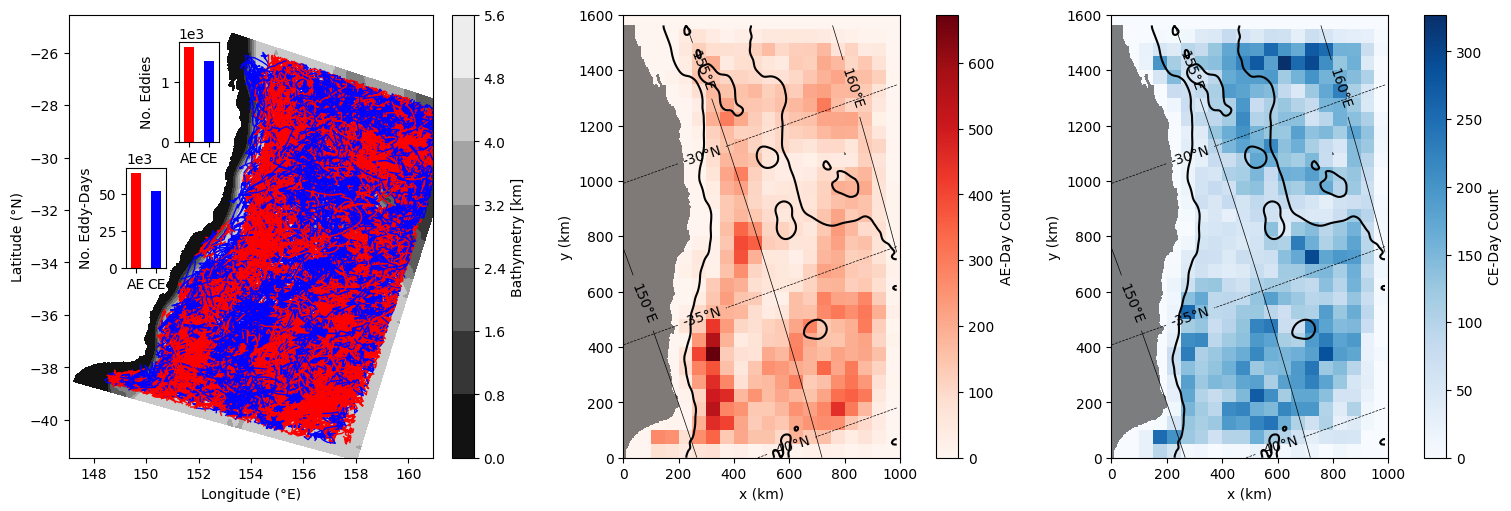

In [57]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# --- Panel 1: Map with eddy tracks and insets ---
ax = axs[0]
cs = ax.contourf(lon_rho, lat_rho, np.where(mask_rho, h/1000, np.nan), cmap='grey')
fig.colorbar(cs, ax=ax, label='Bathymetry [km]')

for eddy in df_eddies.Eddy.unique():
    d = df_eddies[df_eddies.Eddy == eddy]
    # ax.plot(d.Lon, d.Lat, lw=1, alpha=1)
    cyc = d.iloc[0].Cyc
    ax.plot(d.Lon, d.Lat, color='r' if cyc=='AE' else 'b', lw=1, alpha=1)

ax.axis('equal')
ax.set_xlim(148, 160)
ax.set_ylim(-40, -26)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')

# Inset 1: Eddy counts
df_unique = df_eddies[['Eddy', 'Cyc']].drop_duplicates()
in_ax1 = inset_axes(ax, width=.4, height=1, loc='center',
                   bbox_to_anchor=(152, -27.5, 0, 0),
                   bbox_transform=ax.transData, borderpad=0)
counts = df_unique['Cyc'].value_counts().reindex(['AE','CE']).fillna(0)
counts.plot(kind='bar', color=['r','b'], ax=in_ax1)
in_ax1.set_xlabel('')
in_ax1.set_ylabel('No. Eddies')
in_ax1.tick_params(axis='x', rotation=0)
in_ax1.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
in_ax1.set_facecolor('none')

# Inset 2: Eddy-day counts
in_ax2 = inset_axes(ax, width=.4, height=1, loc='center',
                   bbox_to_anchor=(150, -32.3, 0, 0),
                   bbox_transform=ax.transData, borderpad=0)
counts = df_eddies['Cyc'].value_counts().reindex(['AE','CE']).fillna(0)
counts.plot(kind='bar', color=['r','b'], ax=in_ax2)
in_ax2.set_xlabel('')
in_ax2.set_ylabel('No. Eddy-Days')
in_ax2.tick_params(axis='x', rotation=0)
in_ax2.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
in_ax2.set_facecolor('none')

# --- Panel 2 & 3: Eddy-day distributions ---
for d, subset in enumerate([df_eddies[df_eddies.Cyc == 'AE'], df_eddies[df_eddies.Cyc == 'CE']]):
    x0, y0 = X_grid[0, 0], Y_grid[0, 0]
    eddy_x = X_grid[subset.ic, subset.jc] - x0
    eddy_y = Y_grid[subset.ic, subset.jc] - y0
    
    bin_km = 50
    x_edges = np.arange(X_grid.min(), X_grid.max() + bin_km, bin_km)
    y_edges = np.arange(Y_grid.min(), Y_grid.max() + bin_km, bin_km)
    
    H, _, _ = np.histogram2d(eddy_y, eddy_x, bins=[y_edges, x_edges])
    
    pcm = axs[d+1].pcolormesh(x_edges, y_edges, H, cmap='Reds' if d==0 else 'Blues')
    fig.colorbar(pcm, ax=axs[d+1], label='AE-Day Count' if d==0 else 'CE-Day Count')
    
    axs[d+1].contourf(X_grid - x0, Y_grid - y0, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = axs[d+1].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    axs[d+1].clabel(c1, fmt=lambda v: f"{v:.0f}°N", inline=True, colors='k')
    c2 = axs[d+1].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    axs[d+1].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    axs[d+1].set_xlabel('x (km)')
    axs[d+1].set_ylabel('y (km)')
    axs[d+1].set_aspect('equal')

    axs[d+1].contour(X_grid, Y_grid, h, levels=[4000], colors='k')

# plt.tight_layout()
plt.show()


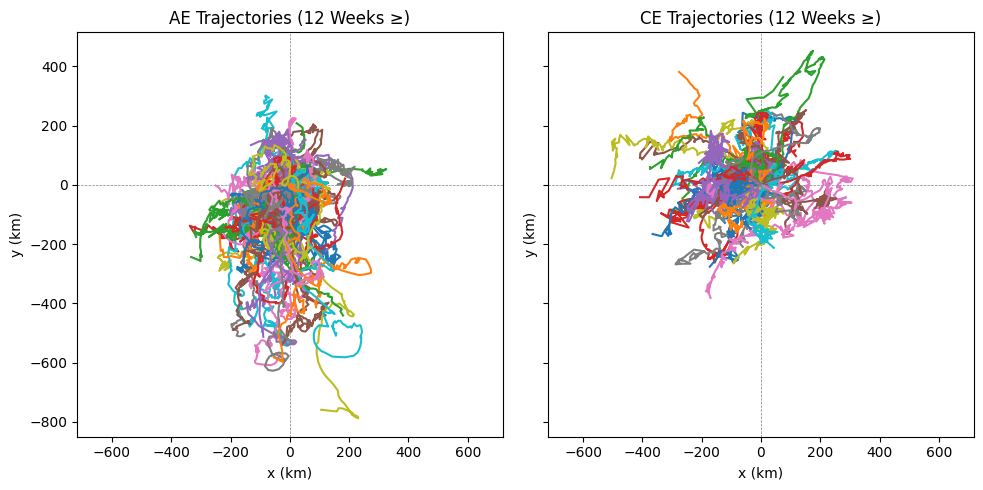

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
axs[0].axhline(y=0, color='k', ls='--', alpha=.5, lw=.5); axs[0].axvline(x=0, color='k', ls='--', alpha=.5, lw=.5)
axs[1].axhline(y=0, color='k', ls='--', alpha=.5, lw=.5); axs[1].axvline(x=0, color='k', ls='--', alpha=.5, lw=.5)
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if df.iloc[0].Age >= 12*7:
        if df.iloc[0].Cyc == 'AE':
            axs[0].plot(df.xc-df.iloc[0].xc, df.yc-df.iloc[0].yc)
        else:
            axs[1].plot(df.xc-df.iloc[0].xc, df.yc-df.iloc[0].yc)
axs[0].axis('equal'); axs[1].axis('equal')
axs[0].set_title('AE Trajectories (12 Weeks ≥)')
axs[1].set_title('CE Trajectories (12 Weeks ≥)')
axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
axs[1].set_xlabel('x (km)'); axs[1].set_ylabel('y (km)')
axs[0].set_xlim(-600, 600); axs[1].set_xlim(-600, 600)
plt.tight_layout()


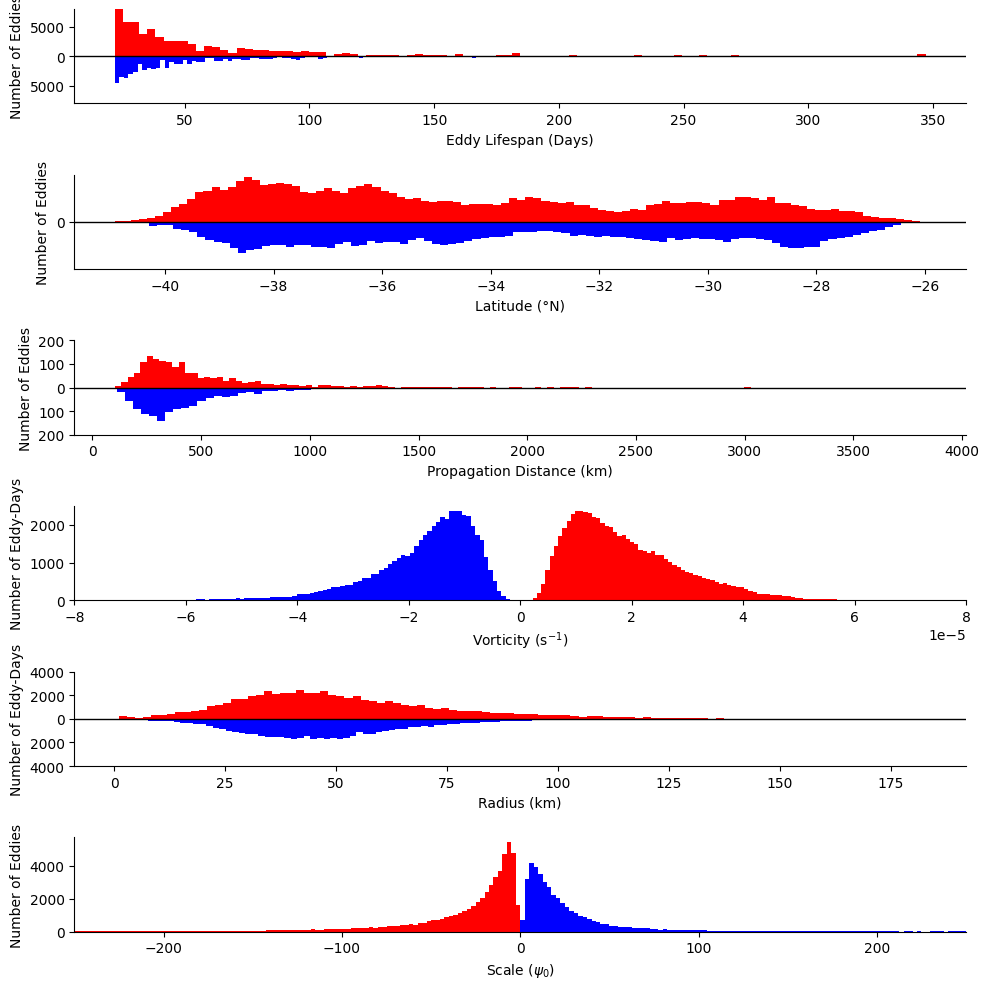

In [55]:
fig, axs = plt.subplots(6, 1, figsize=(10, 10))

# --- Plot 1: Age ---
ages_ae = df_eddies[df_eddies.Cyc == 'AE'].Age
ages_ce = df_eddies[df_eddies.Cyc == 'CE'].Age
axs[0].hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
axs[0].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
# ylims = axs[0].get_ylim()
# axs[0].set_ylim(-np.max(np.abs(ylims)), np.max(np.abs(ylims)))
axs[0].axhline(0, color='k', linewidth=1)
axs[0].set_xlabel('Eddy Lifespan (Days)')
axs[0].set_ylabel('Number of Eddies')
# axs[0].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_yticks(axs[0].get_yticks())
axs[0].set_yticklabels([abs(int(t)) for t in axs[0].get_yticks()])
axs[0].set_ylim(-8000, 8000)

# --- Plot 2: Lat ---
ages_ae = df_eddies[df_eddies.Cyc == 'AE'].Lat
ages_ce = df_eddies[df_eddies.Cyc == 'CE'].Lat
axs[1].hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
axs[1].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
# ylims = axs[1].get_ylim()
# axs[1].set_ylim(-np.max(np.abs(ylims)), np.max(np.abs(ylims)))

axs[1].axhline(0, color='k', linewidth=1)
axs[1].set_xlabel('Latitude (°N)')
axs[1].set_ylabel('Number of Eddies')
# axs[0].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_yticks(axs[0].get_yticks())
axs[1].set_yticklabels([abs(int(t)) for t in axs[0].get_yticks()])
axs[1].set_ylim(-1500, 1500)

# --- Plot 2: Propagation Distance ---
eddy_props_AE, eddy_props_CE = [], []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    dist = np.nansum(np.hypot(df.xc.diff(), df.yc.diff()))
    (eddy_props_AE if df.iloc[0].Cyc=='AE' else eddy_props_CE).append(dist)
axs[2].hist(eddy_props_AE, bins=100, color='r')
counts, bins = np.histogram(eddy_props_CE, bins=100)
axs[2].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ylims = axs[2].get_ylim()
axs[2].set_ylim(-np.max(np.abs(ylims)), np.max(np.abs(ylims)))
axs[2].axhline(0, color='k', linewidth=1)
axs[2].set_xlabel('Propagation Distance (km)')
axs[2].set_ylabel('Number of Eddies')
# axs[2].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].set_yticks(axs[2].get_yticks())
axs[2].set_yticklabels([abs(int(t)) for t in axs[2].get_yticks()])

# --- Plot 3: Vorticity ---
df_v = df_eddies[df_eddies.w.abs() <= 8e-5]
axs[3].hist(df_v[df_v.Cyc=='AE'].w, bins=100, color='r')
axs[3].hist(df_v[df_v.Cyc=='CE'].w, bins=100, color='b')
axs[3].set_xlim(-8e-5, 8e-5)
axs[3].set_xlabel(r'Vorticity (s$^{-1}$)')
axs[3].set_ylabel('Number of Eddy-Days')
axs[3].spines['top'].set_visible(False)
axs[3].spines['right'].set_visible(False)

# --- Plot 4: Radius ---
axs[4].hist(df_eddies[df_eddies.Cyc=='AE'].Rc, bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc=='CE'].Rc, bins=100)
axs[4].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
# ylims = axs[4].get_ylim()
# axs[4].set_ylim(-np.max(np.abs(ylims)), np.max(np.abs(ylims)))
axs[4].set_ylim(-2500, 2500)
axs[4].axhline(0, color='k', linewidth=1)
axs[4].set_xlabel('Radius (km)')
axs[4].set_ylabel('Number of Eddy-Days')
# axs[4].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
axs[4].spines['top'].set_visible(False)
axs[4].spines['right'].set_visible(False)
axs[4].set_yticks(axs[4].get_yticks())
axs[4].set_yticklabels([abs(int(t)) for t in axs[4].get_yticks()])

# --- Plot 5: Scale (psi0) ---
df_p = df_eddies[df_eddies.psi0.abs() < 250]
axs[5].hist(df_p[df_p.Cyc=='AE'].psi0, bins=100, color='r')
axs[5].hist(df_p[df_p.Cyc=='CE'].psi0, bins=100, color='b')
axs[5].set_xlim(-250, 250)
axs[5].set_xlabel(r'Scale ($\psi_0$)')
axs[5].set_ylabel('Number of Eddies')
axs[5].spines['top'].set_visible(False)
axs[5].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()



In [8]:
np.mean(eddy_props_AE)

np.float64(483.0680081849248)

In [9]:
np.mean(eddy_props_CE)

np.float64(471.5276950435691)

In [10]:
N = len(eddy_props_AE)
M = len(eddy_props_CE)
N/(N+M)*np.mean(eddy_props_AE) + M/(N+M)*np.mean(eddy_props_CE) 

np.float64(477.7453492369131)

In [11]:
eddy_props = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    dist = np.nansum(np.hypot(df.xc.diff(), df.yc.diff()))
    eddy_props.append(dist)

In [12]:
np.mean(eddy_props)

np.float64(477.74534923691306)

In [13]:
df_AE, df_CE = df_eddies[df_eddies.Cyc=='AE'], df_eddies[df_eddies.Cyc=='CE']

In [14]:
df_CE.w.mean()

np.float64(-1.723794595637761e-05)

In [15]:
df_eddies.Rc.min()

np.float64(0.19717311378470265)

In [16]:
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if df.Rc.mean() <= 15:
        print(eddy)

    

In [17]:
df_eddies

,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [40]:
df_CE.Rc.min()

np.float64(0.19717311378470265)

In [34]:
np.mean(eddy_props)

np.float64(477.74534923691306)

In [30]:
eddy_props = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    dist = np.nansum(np.hypot(df.xc.diff(), df.yc.diff()))
    eddy_props.append(dist)